# <b>DSCI-100 Project Final Report</b>

**Names:** Ziwangyue Yin, Kevin Li, Zihao Yang, and Kyle Li\
**Section:** 003\
**Group:** 9\
**Date:** _______, 2025

In [1]:
## Necessary Components to Preload

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## <b>(1.0) Introduction:</b>

### 1.1 Background Information:

The data we are provided in this project are the _players.csv_ and _sessions.csv_ datasets which originate from a Minecraft server run by a research group in Computer Science at UBC. The goal of this Minecraft server is to ultimately use player input data to train AI. However, we will only be analyzing the _players.csv_ as the predictive question we aim to answer doesn't require the _sessions.csv_ dataset. The specificity of this question will be expanded upon in the subsequent section. It is important to note that the _players.csv_ data presented was gathered via self-reporting during server signup and compiled into a csv by the researchers. WILL EDIT LATER*****

### 1.2 Questions We Aim to Answer:

### 1.2.1 Broad Question

What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

### 1.2.2 Specific Question

Can a player’s experience, and age be used to accurately predict their newsletter subscription status in players dataset?

### 1.3 Dataset Description:

In this section, we are firstly going to create an overview of _players.csv_. Subsequently, we will then identify and define the characteristics of the dataset and finally summarize its statistics.

<u><b>Overview of Players Dataset:</u></b>
| Dataset | Number of Observations | Number of Variables | Represents |  
|:-----|:---:|:---:|:-----|
| players.csv | 196 | 7 | Data and list of all unique players involved with the server. |

<u><b>Player Dataset:</u></b>

**a) Variables**
| Variable | Type | Short Description |
|:-----|:-----|:-----|
| experience | Character | Self-reported level of experience with Minecraft. This ranged from Beginner -> Amateur -> Reguler -> Veteran -> Pro |
| subscribe | Logical (T/F) | Whether a player had suscribed to a game-related newsletter (yes = True, no = False) |
| hashedEmail | Character | Unique identifier of each player (anonymizing their emails via hashing) |
| played_hours | Numeric (dbl) | Hours spent on the Minecraft server for each participant |
| name | Character | First names (not gamertag) of each individual participating|
| gender | Character | Gender of each individual participating |
| Age | Numeric (dbl) | Age in years of each individual participating |

**b) Summary Statistics**
| Variable | Value (round to 2 decimals if possible) | 
|:-----|:-----:|
| Mean Age | 21.14 |
| Youngest Age | 9 |
| Oldest Age | 58 |
| Standard Deviation of Age | 7.39 | 
| Mean Hours Played | 5.85 |
| Highest Number of Hours Played | 223.1|
| Lowest Number of Hours Played | 0 |
| Standard Deviation of Hours Played | 28.36 | 
| Number of Players | 196 | 
| Proportion Subscribed (%) | 73.47 | 

Note: Since we know that each player (196 total) has a unique identifier and a first name, we also know that the number of hashed emails and names also equal to 196. Furthermore, for the sake of simplicity, we will not be presenting gender or experience proportions in the Summary Statistics table.

## <b>(2.0) Methods & Results:</b>

To answer our specific question, the first thing we need to determine is which method we will use for prediction. For predicting subscription status, we will use the K-nearest neighbors (KNN) classification method.  
The reason for this choice is that classification aims to predict a categorical class for an observation based on its other variables, and in our case, subscription status is a categorical variable.

### 2.1 Loading Dataset:

Since we only require the _players.csv_ dataset for our project, we will firstly need to load it.\
As such:

In [2]:
url_players <- "https://raw.githubusercontent.com/Sandyyyin/project_final_report/refs/heads/main/players.csv"
players_data <- read_csv(url_players)

players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


### 2.2 Wrangling Data:

First, we select the response variable (subscribe) and two explanatory variables (experience and age). We noticed that there are NA values in the age variable, which are uninformative. Therefore, we removed these records.

In [20]:
wrangling_players_data <- players_data |>
    select(subscribe, experience, Age) |>
    filter(!is.na(Age))

Since we will be working with subscribe as a categorical variable, it is a good idea to convert it to a factor type. In addition, because KNN classification uses distances for prediction, it is necessary to convert experience to a numerical type. Here, we assign numerical values to experience based on familiarity levels: beginner (0), amateur (1), regular (2), veteran (3), and pro (4).

In [21]:
wrangling_players_data <- wrangling_players_data |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(experience = recode(experience,
                               "Beginner" = "0",
                               "Amateur" = "1",
                               "Regular" = "2",
                               "Veteran" = "3",
                               "Pro" = "4")) |>
    mutate(experience = as.numeric(experience))
wrangling_players_data

subscribe,experience,Age
<fct>,<dbl>,<dbl>
TRUE,4,9
TRUE,3,17
FALSE,3,17
⋮,⋮,⋮
FALSE,3,22
FALSE,1,57
FALSE,1,17


### 2.3 Visualization:

Note: Keep in mind that for 'Subscription Status', TRUE = subscribed to game-related newsletter and FALSE = not subscribed to the newsletter! 

#### 2.3.1 Bar plot of experience distribution by subscription status:

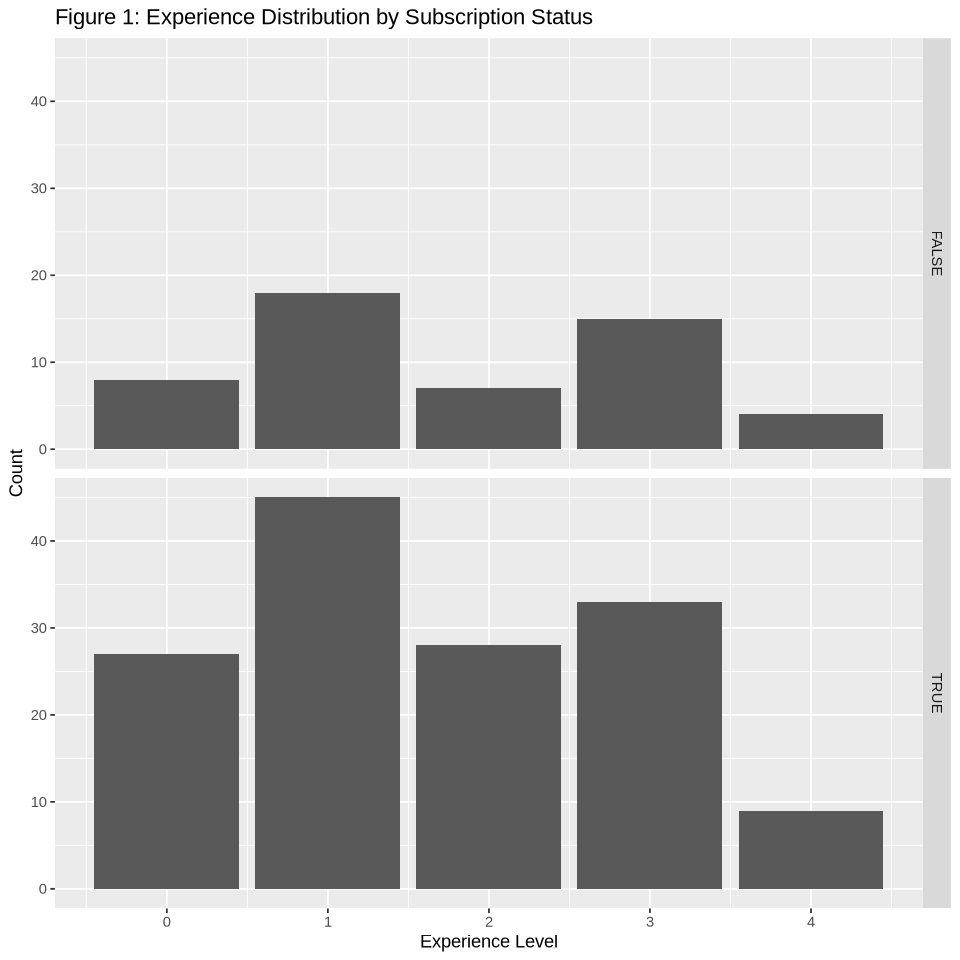

In [27]:
options(repr.plot.width = 8, repr.plot.height = 8) 

experi_subs <- wrangling_players_data |>
    ggplot(aes(x = experience)) +
    geom_bar() +
    facet_grid(subscribe ~ .) +
    labs(x = "Experience Level",
         y = "Count",
         title = "Figure 1: Experience Distribution by Subscription Status")

experi_subs

#### 2.3.1 Bar plot of age distribution by subscription status:

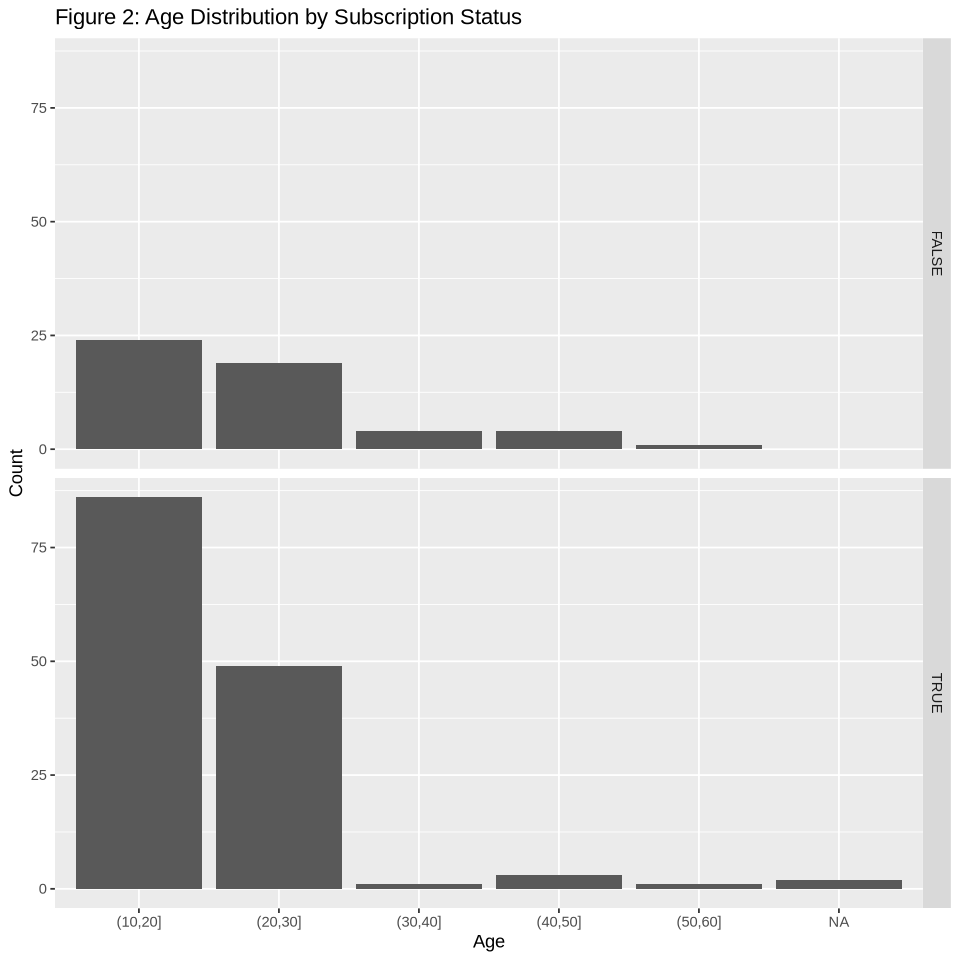

In [28]:
options(repr.plot.width = 8, repr.plot.height = 8) 

age_group_players_data <- wrangling_players_data |>
    mutate(age_group = cut(Age, breaks = seq(10, 60, by = 10)))

age_subs <- age_group_players_data |>
    ggplot(aes(x = age_group)) +
    geom_bar() +
    facet_grid(subscribe ~ .) +
    labs(x = "Age",
         y = "Count",
         title = "Figure 2: Age Distribution by Subscription Status")

age_subs

### 2.3 Standarization:

Since the classifier predicts classes by identifying the nearest observations, variables with larger scales will have a much greater influence than those with smaller scales. To avoid this issue and improve the accuracy of our model, we need to standardize the variables.

In [12]:
players_data_recipe <- recipe(subscribe ~ ., data = wrangling_players_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()

scaled_players_data <- bake(players_data_recipe, wrangling_players_data)
scaled_players_data

experience,Age,subscribe
<dbl>,<dbl>,<fct>
1.895915,-1.6427185,TRUE
1.073079,-0.5601286,TRUE
1.073079,-0.5601286,FALSE
⋮,⋮,⋮
1.0730793,0.1164900,FALSE
-0.5725917,4.8528206,FALSE
-0.5725917,-0.5601286,FALSE


## <b>(3.0) Discussion:</b>

Requirement:
- summarize what you found
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to

## <b>(4.0) GitHub Link:</b>

## <b>(5.0) References:</b>